## Code to run Main3d.py





> Start PINN Algorithm




> Adapting PDE


> Adapting Mesh


> Creating NeuralNet

{
    "input_shape": [
        null,
        3
    ],
    "num_hidden_blocks": 5,
    "num_neurons_per_layer": 20,
    "output_dim": 1,
    "activation": "tanh",
    "architecture_Net": "ResNet"
}

Model: "pinn__neural_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (Lambda)        multiple                  0         
                                                                 
 layer_0 (Dense)             multiple                  80        
                                                                 
 block_0 (Sequential)        (None, 20)                840       
                                                                 
 block_1 (Sequential)        (None, 20)                840       
                                                                 
 block_2 (Sequential)       

Loss: 8.5382e+01: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]



Computation time: 16.370392322540283 seconds

> Saving model: Test_PINN


Loss: 8.538e+01

> Ploting Solution



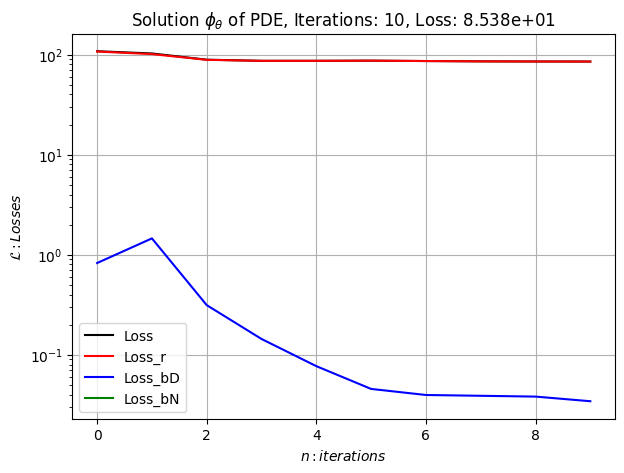

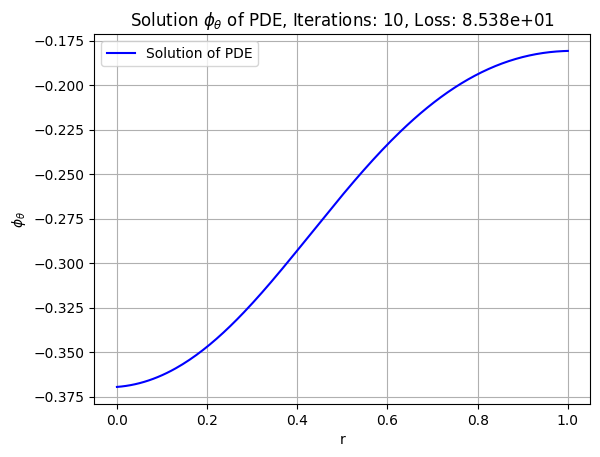

In [1]:
%run Main3d.py

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os
import types
import json
import logging
import sys
import shutil

from PDE_Model import PDE_Model
from PDE_Model import PDE_Model_2
from Preconditioner import Preconditioner
from Preconditioner import change_fun

from Mesh import Mesh
from NN.NeuralNet import PINN_NeuralNet

from NN.PINN import PINN
from NN.Postprocessing import View_results
from NN.PINN import PINN_Precond

from NN.XPINN import XPINN
from NN.Postprocessing import View_results_X
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

main_path = os.path.join(os.path.dirname(os.path.abspath(__file__)),'results')
if os.path.exists(main_path):
        shutil.rmtree(main_path)
os.makedirs(main_path)

filename = os.path.join(main_path,'logfile.log')
LOG_format = '%(levelname)s - %(name)s: %(message)s'
logging.basicConfig(filename=filename, filemode='w', level=logging.INFO, format=LOG_format)
logger = logging.getLogger(__name__)

logger.info("==============================")




for hidden in range(5,6):

        folder_path = os.path.join(main_path,'results_sim_FCNN_'+str(hidden))
        if os.path.exists(folder_path):
                shutil.rmtree(folder_path)
        os.makedirs(folder_path)

        logger.info("> Starting PINN Algorithm")

        domain = ([-1,1],[-1,1],[-1,1])
        PDE = PDE_Model()
        domain = PDE.set_domain(domain)
        PDE.sigma = 0.04
        PDE.epsilon = 1

        lb = {'type':'D', 'value':-1/(4*np.pi*PDE.epsilon), 'fun':None, 'dr':None, 'r':1}
        borders = {'1':lb}
        ins_domain = {'rmax': 1}

        PINN_solver = PINN()

        logger.info("> Adapting PDE")

        PINN_solver.adapt_PDE(PDE)
        weights = {
                'w_r': 1,
                'w_d': 1,
                'w_n': 1,
                'w_i': 1
        }

        logger.info("> Adapting Mesh")

        mesh1 = Mesh(domain, N_b=60, N_r=1500)
        mesh1.create_mesh(borders, ins_domain)
        #mesh1.plot_points_2d();
        PINN_solver.adapt_mesh(mesh1,**weights)

        logger.info("> Creating NeuralNet")

        lr = ([3000,6000],[1e-2,5e-3,5e-4])
        hyperparameters_FCNN = {
                'input_shape': (None,3),
                'num_hidden_layers': hidden,
                'num_neurons_per_layer': 30,
                'output_dim': 1,
                'activation': 'tanh',
                'architecture_Net': 'FCNN'
        }
        
        hyperparameters = hyperparameters_FCNN

        PINN_solver.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

        logger.info(json.dumps(hyperparameters, indent=4))
        PINN_solver.model.summary()

        logger.info("> Solving PINN")

        N_iters = 5
        PINN_solver.solve(N=N_iters)

        Post = View_results(PINN_solver, save=True, directory=folder_path, data=True)

        logger.info("> Ploting Solution")

        Post.plot_loss_history();
        Post.plot_u_domain_contour();
        Post.plot_u_plane();

        if Post.data:
                Post.close_file()

        logger.info('================================================')
        logger.info('================================================')


for blocks in range(5,6):

        folder_path = os.path.join(main_path,'results_sim_ResNet_'+str(blocks))
        if os.path.exists(folder_path):
                shutil.rmtree(folder_path)
        os.makedirs(folder_path)

        logger.info("> Starting PINN Algorithm")

        domain = ([-1,1],[-1,1],[-1,1])
        PDE = PDE_Model()
        domain = PDE.set_domain(domain)
        PDE.sigma = 0.04
        PDE.epsilon = 1

        lb = {'type':'D', 'value':-1/(4*np.pi*PDE.epsilon), 'fun':None, 'dr':None, 'r':1}
        borders = {'1':lb}
        ins_domain = {'rmax': 1}

        PINN_solver = PINN()

        logger.info("> Adapting PDE")

        PINN_solver.adapt_PDE(PDE)
        weights = {
                'w_r': 1,
                'w_d': 1,
                'w_n': 1,
                'w_i': 1
        }

        logger.info("> Adapting Mesh")

        mesh1 = Mesh(domain, N_b=60, N_r=1500)
        mesh1.create_mesh(borders, ins_domain)
        #mesh1.plot_points_2d();
        PINN_solver.adapt_mesh(mesh1,**weights)

        logger.info("> Creating NeuralNet")

        lr = ([3000,6000],[1e-2,5e-3,5e-4])

        hyperparameters_ResNet = {
                'input_shape': (None,3),
                'num_hidden_blocks': blocks,
                'num_neurons_per_layer': 30,
                'output_dim': 1,
                'activation': 'tanh',
                'architecture_Net': 'ResNet'
        }
        
        hyperparameters = hyperparameters_ResNet

        PINN_solver.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

        logger.info(json.dumps(hyperparameters, indent=4))
        PINN_solver.model.summary()

        logger.info("> Solving PINN")

        N_iters = 5
        PINN_solver.solve(N=N_iters)

        Post = View_results(PINN_solver, save=True, directory=folder_path, data=True)

        logger.info("> Ploting Solution")

        Post.plot_loss_history();

        Post.plot_u_plane();

        Post.plot_u_domain_contour();

        if Post.data:
                Post.close_file()

        logger.info('================================================')
        logger.info('================================================')





NameError: name '__file__' is not defined

In [3]:
filename = os.path.join('logfile.log')
LOG_format = '%(levelname)s - %(name)s: %(message)s'
logging.basicConfig(filename=filename, filemode='w', level=logging.INFO, format=LOG_format)
logger = logging.getLogger(__name__)

In [6]:
domain = ([-1,1],[-1,1],[-1,1])
PDE = PDE_Model()
domain = PDE.set_domain(domain)
PDE.sigma = 0.04
PDE.epsilon = 1

lb = {'type':'D', 'value':-1/(4*np.pi*PDE.epsilon), 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

PINN_solver = PINN()

logger.info("> Adapting PDE")

PINN_solver.adapt_PDE(PDE)
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}

logger.info("> Adapting Mesh")

mesh1 = Mesh(domain, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
#mesh1.plot_points_2d();
PINN_solver.adapt_mesh(mesh1,**weights)

logger.info("> Creating NeuralNet")

lr = ([3000,6000],[1e-2,5e-3,5e-4])
hyperparameters_FCNN = {
        'input_shape': (None,3),
        'num_hidden_layers': 3,
        'num_neurons_per_layer': 30,
        'output_dim': 1,
        'activation': 'tanh',
        'architecture_Net': 'FCNN'
}

hyperparameters = hyperparameters_FCNN

PINN_solver.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

logger.info(json.dumps(hyperparameters, indent=4))
PINN_solver.model.summary()

logger.info("> Solving PINN")

N_iters = 5
PINN_solver.solve(N=N_iters)
folder_path = 'results'
Post = View_results(PINN_solver, save=True, directory=folder_path, data=True)

logger.info("> Ploting Solution")




Model: "pinn__neural_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (Lambda)        multiple                  0         
                                                                 
 layer_0 (Dense)             multiple                  120       
                                                                 
 layer_1 (Dense)             multiple                  930       
                                                                 
 layer_2 (Dense)             multiple                  930       
                                                                 
 layer_output (Dense)        multiple                  31        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________


Loss: 100 : 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


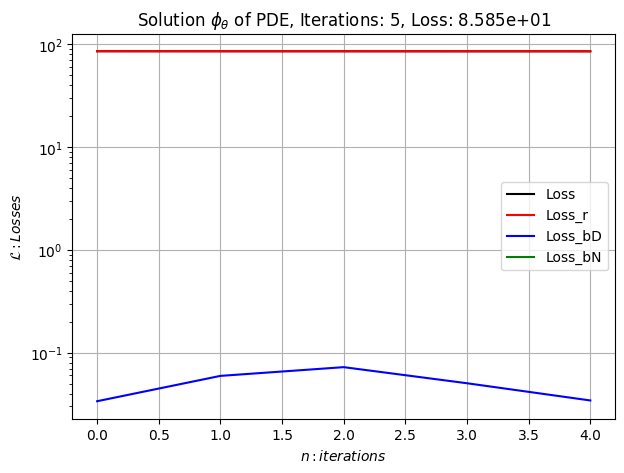

In [7]:
Post.plot_loss_history();


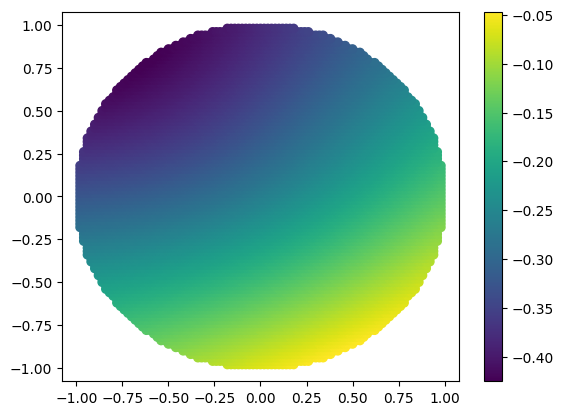

In [8]:
Post.plot_u_domain_contour();


In [9]:
x,y,z,u = Post.get_u_domain(100)
plane = np.abs(z)<10**-4


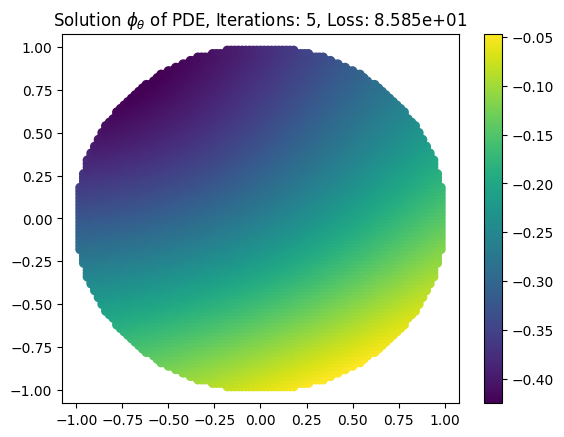

In [13]:

fig, ax = plt.subplots()

s = ax.scatter(x[plane], y[plane], c=u[plane])
fig.colorbar(s, ax=ax)
#ax.grid()
loss = np.format_float_scientific(Post.NN.loss_hist[-1], unique=False, precision=3)
text_l = r'$\phi_{\theta}$'
ax.set_title(f'Solution {text_l} of PDE, Iterations: {Post.NN.N_iters}, Loss: {loss}')

if True:
    path = 'contour.png'
    path_save = os.path.join(path)
    fig.savefig(path_save)
    logger.info(f'Contour Plot saved: {path}')